In [1]:
import math
import random
import numpy as np
import numpy.ma as ma

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from nim_env import NimEnv, OptimalPlayer
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#State and next state vectors (datatype tensor) of 9 bits
#Action index of the made action
#Reward -1,0,1

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(in_features=9,out_features=128)
        self.layer2 = nn.Linear(in_features=128,out_features=128)
        self.head = nn.Linear(in_features=128,out_features=21)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #x size 64x9
        x = F.relu(self.layer1(x)) #64x128
        x = F.relu(self.layer2(x)) #64x128
        return self.head(x) #64x21

In [4]:
def heaps_to_bits(heaps):
    #Return vector of length 9
    #Heap numbers from 1
    #If [0,0,0] -> None
    if heaps == [0,0,0]:
        return None
    else:
        return [int(bin(heaps[0])[2:].zfill(3)[-3]), int(bin(heaps[0])[2:].zfill(3)[-2]), int(bin(heaps[0])[2:].zfill(3)[-1]),
               int(bin(heaps[1])[2:].zfill(3)[-3]), int(bin(heaps[1])[2:].zfill(3)[-2]), int(bin(heaps[1])[2:].zfill(3)[-1]),
               int(bin(heaps[2])[2:].zfill(3)[-3]), int(bin(heaps[2])[2:].zfill(3)[-2]), int(bin(heaps[2])[2:].zfill(3)[-1])]

In [37]:
#Copy pasted so that we remember to create same methods
class NimDQNlearningAgent:
    #Q learning agent for Nim with epsilon-greedy policy
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.1, player=0, buffer_size=10000, batch_size=64, target_network=None, policy_network=None, ReplayBuffer=None, useBuffer=True):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player #  0 or 1
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.useBuffer = useBuffer
        
        #Initialize replay buffer
        if self.useBuffer:
            if ReplayBuffer is not None:
                self.buffer = ReplayBuffer
            else:
                self.buffer = ReplayMemory(self.buffer_size)
        
        #Initialize networks
        if policy_network is not None:
            self.policy_network = policy_network
        else:
            self.policy_network = DQN()
        if target_network is not None:
            self.target_network = target_network
        else:
            self.target_network = DQN()
            self.target_network.load_state_dict(self.policy_network.state_dict())
            
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=0.0005)
    
    def copy(self):
        return NimDQNlearningAgent(alpha=self.alpha, gamma=self.gamma, epsilon=self.epsilon, player=self.player, buffer_size=self.buffer_size, batch_size=self.batch_size, target_network=self.target_network, policy_network=self.policy_network, ReplayBuffer=self.buffer, useBuffer=self.useBuffer)
    
    def randomMove(self, heaps):
        # choose a random move from the available heaps
        heaps_avail = [i for i in range(len(heaps)) if heaps[i] > 0]
        chosen_heap = random.choice(heaps_avail)
        n_obj = random.choice(range(1, heaps[chosen_heap] + 1))
        move = [chosen_heap + 1, n_obj]
        return move
    
    def act(self, heaps):
        # take a state, return the action with max Q-value
        if random.random() < self.epsilon:
            return self.randomMove(heaps)
        else:
            #Q values from policy network
            s = heaps_to_bits(heaps)
            Q = self.policy_network(torch.tensor(s).float())
            i_max = np.argmax(Q.detach().numpy())
            #Transform into heap number and number of sticks
            move = [i_max//7+1, i_max%7+1]
            return move
        
    def update(self, oldHeaps, move, newHeaps, reward):
        old_state = torch.tensor(heaps_to_bits(oldHeaps)).float()
        new_state = heaps_to_bits(newHeaps)
        if new_state is not None:
            new_state = torch.tensor(new_state).float()
        index_of_move = torch.tensor([(move[0]-1)*7 + move[1]-1]).float()
        reward = torch.tensor([reward]).float()
        
        if self.useBuffer:
            #Save to replay buffer
            self.buffer.push(old_state,index_of_move,new_state,reward)
            #Sample from replay if possible and update policy netwok
            if len(self.buffer) < self.batch_size:
                return None
            transitions = self.buffer.sample(self.batch_size)
            # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
            # detailed explanation). This converts batch-array of Transitions
            # to Transition of batch-arrays.
            batch = Transition(*zip(*transitions))
        else:
            batch = Transition(old_state,index_of_move,new_state,reward)
            
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        non_final_next_states = non_final_next_states.view(int(non_final_next_states.size()[0]/9),9)
        state_batch = torch.cat(batch.state).view(self.batch_size,9)
        action_batch = torch.cat(batch.action).long()
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch.view(-1,1))

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size)
        next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        #for param in policy_net.parameters():
            #param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        return loss.item()
        
    def update_target(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

In [41]:
def get_epsilonN(gameNumber, exploreGames, epsilonMin=0.1, epsilonMax=0.8):
    return max(epsilonMin, epsilonMax * (1 - gameNumber/exploreGames))

def playGames(env, player1, player2, decreaseExploration, exploGames=None, numGames=20000, update_cycle=500):
    reward_sum = 0
    loss_sum = 0.0
    loss_count = 0
    games_won = 0
    avg_rewards = []
    avg_train_loss = []
    M_opts = []
    M_rands = []
    for i in range(numGames):
        if decreaseExploration:
            player1.epsilon = get_epsilonN(i+1, exploGames)
        env.reset()
        lastActionState = None
        lastAction = None
        end_with_unavailable = False
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player2.player:
                move = player2.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                if (lastActionState is not None and lastAction is not None):
                    reward = env.reward(player=player1.player)
                    # update Q-values for the last state where the Q-learning agent was playing
                    loss = player1.update(lastActionState, lastAction, newHeaps, reward)
                    if loss is not None:
                        loss_sum += loss
                        loss_count += 1
                lastActionState = heaps.copy()
                move = player1.act(heaps)
                lastAction = move
                #Possibility to have unavailable action
                #If error, give reward -1 and end the game
                try:
                    newHeaps, end, winner = env.step(move)
                except AssertionError:
                    reward = -1
                    newHeaps = [0,0,0]
                    end = True
                    winner = player2.player
                    end_with_unavailable = True

            if end:
                if not end_with_unavailable:
                    reward = env.reward(player=player1.player)
                loss = player1.update(lastActionState, lastAction, newHeaps, reward)
                reward_sum += reward
                if loss is not None:
                        loss_sum += loss
                        loss_count += 1
                if reward > 0:
                    games_won += 1
                if ( (i+1) % 250 == 0):
                    #compute statistics
                    avg_rewards.append(reward_sum / 250)
                    avg_train_loss.append(loss_sum / loss_count)
                    reward_sum = 0
                    loss_sum = 0.0
                    loss_count = 0
                    M_opt = calc_M(player1, 0)
                    M_rand = calc_M(player1, 1)
                    M_opts.append(M_opt)
                    M_rands.append(M_rand)
                break
        # switch players
        player1.player = 1 - player1.player
        player2.player = 1 - player2.player
        
        #Every 500 game udate targer
        if (i+1) % update_cycle == 0:
            player1.update_target()
        
    
    print(f"Winrate: {games_won/numGames}")
    return avg_rewards, avg_train_loss, M_opts, M_rands

def calc_M(player, epsilon, N=500):
    player_test = player.copy()
    player_test.player = 0
    player_test.epsilon = 0
    player_opt = OptimalPlayer(epsilon=epsilon, player=1)
    games_won = 0
    for i in range(N):
        env = NimEnv(seed=i)
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player_opt.player:
                move = player_opt.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                move = player_test.act(heaps)
                try:
                    newHeaps, end, winner = env.step(move)
                except AssertionError:
                    break
            if end:
                reward = env.reward(player=player_test.player)
                if reward > 0:
                    games_won += 1
                break

        player_opt.player = 1 - player_opt.player
        player_test.player = 1 - player_test.player
    
    return (2* games_won - N) / N

In [42]:
env = NimEnv(seed = 10)
random.seed(0)
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
mpl.rcParams.update(params)

In [43]:
# Question 11
player_Q = NimDQNlearningAgent(player=0, epsilon=0.2)
player_opt = OptimalPlayer(epsilon=0.5, player=1)
avg_rewards, avg_train_loss, M_opts, M_rands = playGames(env, player_Q, player_opt, decreaseExploration=False, numGames=1000)

Winrate: 0.265


In [44]:
print(M_opts)
print(M_rands)
print(avg_rewards)
print(avg_train_loss)

[-1.0, -1.0, -1.0, -0.96]
[-0.152, 0.164, 0.296, 0.368]
[-0.76, -0.408, -0.528, -0.184]
[0.0733196148977209, 0.026691944694004145, 0.08546744001141542, 0.07671453185852557]


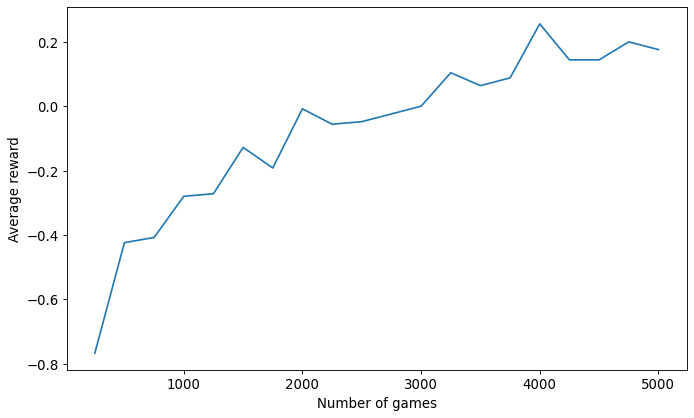

In [10]:
plt.figure(figsize=(10, 6), dpi=80)
ax = sns.lineplot(x=list(range(250, 1001, 250)), y=avg_rewards)
ax.set(ylabel="Average reward", xlabel="Number of games")
plt.show()

None
